In [ ]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #02 - Successive Corrections

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using successive corrections.
[PUT MORE INFORMATION HERE - I.E., WHAT SPECIFIC THING IS BEING DONE]

"""
__author__    = "Jared W. Marquis"
__contact__   = "jared.marquis@und.edu"

In [1]:
### Import Required Modules (shouldn't need to change) ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import math

In [2]:
### Create function for Cressman Analysis ###
def cressman_weight(dik, R):
    if dik > R:
        return 0
    else:
        return (R**2 - dik**2) / (R**2 + dik**2)
def cressman(xob, yob, zob, xg, yg, dmin, radius):
    R = radius * dmin
    analysis = np.zeros_like(xg)
    for i in range(xg.shape[0]):
        for j in range(xg.shape[1]):
            denom = 0
            weight_fork = 0
            for x, y, z in zip(xob, yob, zob):
                dik = np.sqrt((xg[i, j] - x)**2 + (yg[i, j] - y)**2)
                weight = cressman_weight(dik, R)
                weight_fork += weight * z
                denom += weight
            if denom > 0:
                analysis[i, j] = weight_fork / denom
            else:
                analysis[i, j] = np.nan
    return analysis

In [3]:
### Create function for bilinear interpolation ###
def bilinear_interpolate(xob, yob, xg, yg, analysis):
    interpolated_vals = np.zeros(xob.shape)
    for i in range(len(xob)):
        ob_indy = (yob[i]-y0)/del_y
        ob_indx = (xob[i]-x0)/del_x
        if ob_indx > 21 or ob_indx < 0 or ob_indy > 27 or ob_indy < 0:
            interpolated_vals[i] = 0
        else:
            bl_indy = np.floor(ob_indy).astype(int)
            bl_indx = np.floor(ob_indx).astype(int)
            br_indy = np.floor(ob_indy).astype(int)
            br_indx = np.floor(bl_indx + 1).astype(int)
            tl_indy = np.floor(bl_indy + 1).astype(int)
            tl_indx = np.floor(ob_indx).astype(int)
            tr_indy = np.floor(bl_indy + 1).astype(int)
            tr_indx = np.floor(bl_indx + 1).astype(int)
            left_value = analysis[bl_indy, bl_indx] + ((analysis[tl_indy, tl_indx] -  analysis[bl_indy, bl_indx]) / (tl_indy - bl_indy)) * (ob_indy - bl_indy)
            right_value = analysis[br_indy, br_indx] + ((analysis[tr_indy, tr_indx] -  analysis[br_indy, br_indx]) / (tr_indy - br_indy)) * (ob_indy - br_indy)
            bilinear_val = left_value + ((right_value - left_value) / 1) * (ob_indx - bl_indx)
            interpolated_vals[i] = bilinear_val
    return interpolated_vals

In [4]:
### Read in observations ###
AllData = np.loadtxt('RAOBs_201903131200.txt',dtype='str')

Lat = np.ones((np.size(AllData)))*np.nan
Lon = np.ones((np.size(AllData)))*np.nan
GeoHeight = np.ones((np.size(AllData)))*np.nan
WindDir = np.ones((np.size(AllData)))*np.nan
WindSpd = np.ones((np.size(AllData)))*np.nan

for i in range(0,np.size(AllData)):
    Data = AllData[i].split(',')
    Lat[i] = float(Data[1])
    Lon[i] = float(Data[2])
    GeoHeight[i] = float(Data[3])
    WindDir[i] = float(Data[4])
    WindSpd[i] = float(Data[5])


In [5]:
### Set up analysis map with a 22x28 rectangular grid of points ###
x0 = 18.9
y0 = -6.3
del_x = 1.27
del_y = 1.27
x = x0 + np.arange(22) * del_x
y = y0 + np.arange(28) * del_y
xg, yg = np.meshgrid(x,y)

In [6]:
### convert obs lat/long to x,y ###
rho = 6371
lambda0 = -115
lambda0_r = np.radians(lambda0)
phi0 = 60
phi0_r = np.radians(phi0)
map_scale = 1/15000000

Lat_r = np.radians(Lat)
Lon_r = np.radians(Lon)

xkm = rho * (((1 + np.sin(phi0_r))/(1 + np.sin(Lat_r))) * np.cos(Lat_r) * np.cos(Lon_r - lambda0_r))
ykm = rho * (((1 + np.sin(phi0_r))/(1 + np.sin(Lat_r))) * np.cos(Lat_r) * np.sin(Lon_r - lambda0_r))

xcm = xkm * 1E5
ycm = ykm * 1E5

xob = xcm * map_scale
yob = ycm * map_scale

yg_earth = yg / map_scale / 1E5
xg_earth = xg / map_scale / 1E5

Lat_g = np.degrees((np.pi/2) - 2*np.arctan( np.sqrt(xg_earth**2 + yg_earth**2) / (rho*(1+np.sin(phi0_r) ) )))
Lon_g = lambda0 + np.degrees(np.arctan(yg_earth/xg_earth))

In [7]:
### Perform 500mb geopotential height analyses using a Cressman weighting Function###
#Use radii of influence 4, 2.5, 1.5 *dmin
min_distances = []
r1 = 4
r2 = 2.5
r3 = 1.5

for i in range(len(xob)):
    min_dist = np.inf
    for j in range(len(yob)):
        if i != j:
            dxob = xob[i] - xob[j]  
            dyob = yob[i] - yob[j]
            dist = np.sqrt(dxob ** 2 + dyob ** 2)
            if dist < min_dist:
                min_dist = dist
    min_distances.append(min_dist)
dmin = np.mean(min_distances)

In [8]:
### First analysis, no successive corrections ##
R = r1 * dmin
first_pass = np.zeros_like(xg)
for i in range(xg.shape[0]):
    for j in range(xg.shape[1]):
        denom = 0
        weight_fork = 0
        for x, y, z in zip(xob, yob, GeoHeight):
            dik = np.sqrt((xg[i, j] - x)**2 + (yg[i, j] - y)**2)
            weight = cressman_weight(dik, R)
            weight_fork += weight * z
            denom += weight
        if denom > 0:
            first_pass[i, j] = weight_fork / denom
        else:
            first_pass[i, j] = np.nan

In [10]:
### Next Analyses ###
bilinear = bilinear_interpolate(xob, yob, xg, yg, first_pass)
R1 = r1 * dmin
first_analysis = np.zeros_like(xob)
rev_cressman = np.zeros_like(xob)
for i in range(xob.shape[0]):
    second_denom = 0
    weight_fark = 0
    for j in range(xg.shape[0]):
        for k in range(xg.shape[1]):
            second_dik = np.sqrt((xob[i]-xg[j,k])**2+(yob[i]-yg[j,k])**2)
            second_weight = cressman_weight(second_dik,R1)
            weight_fark += second_weight*first_pass[j,k]
            second_denom += second_weight
        if second_denom > 0:
            rev_cressman[i] = weight_fark/second_denom
        else:
            rev_cressman[i] = np.nan
    if bilinear[i] > 0:
        first_analysis[i] = bilinear[i]
    else:
        first_analysis[i] = rev_cressman[i]

R2 = r2 * dmin
second_pass = np.zeros_like(xg)
for i in range(xg.shape[0]):
    for j in range(xg.shape[1]):
        sec_denom = 0
        sec_weight_fork = 0
        for x, y, o, a in zip(xob, yob, GeoHeight, first_analysis):
            sec_dik = np.sqrt((xg[i, j] - x)**2 + (yg[i, j] - y)**2)
            fork_fark =  o - a
            sec_weight = cressman_weight(sec_dik, R2)
            if math.isnan(fork_fark):
                sec_weight_fork += 0
            else:
                sec_weight_fork += sec_weight*fork_fark
            sec_denom += sec_weight
        if sec_denom > 0:
            second_pass[i, j] = first_pass[i, j] + (sec_weight_fork / sec_denom)
        else:
            second_pass[i, j] = np.nan

In [12]:
### Next Analyses ###
bilinear2 = bilinear_interpolate(xob, yob, xg, yg, second_pass)
R2 = r2 * dmin
second_analysis = np.zeros_like(xob)
rev_cressman2 = np.zeros_like(xob)
for i in range(xob.shape[0]):
    third_denom = 0
    weight_fark2 = 0
    for j in range(xg.shape[0]):
        for k in range(xg.shape[1]):
            third_dik = np.sqrt((xob[i]-xg[j,k])**2+(yob[i]-yg[j,k])**2)
            third_weight = cressman_weight(third_dik,R2)
            weight_fark2 += third_weight*second_pass[j,k]
            third_denom += third_weight
        if third_denom > 0:
            rev_cressman2[i] = weight_fark2/third_denom
        else:
            rev_cressman2[i] = np.nan
    if bilinear2[i] > 0:
        second_analysis[i] = bilinear2[i]
    else:
        second_analysis[i] = rev_cressman2[i]
        
R3 = r3 * dmin
third_pass = np.zeros_like(xg)
for i in range(xg.shape[0]):
    for j in range(xg.shape[1]):
        thir_denom = 0
        thir_weight_fork = 0
        for x, y, o, a in zip(xob, yob, GeoHeight, second_analysis):
            thir_dik = np.sqrt((xg[i, j] - x)**2 + (yg[i, j] - y)**2)
            fork_fark2 =  o - a
            thir_weight = cressman_weight(thir_dik, R3)
            if math.isnan(fork_fark2):
                thir_weight_fork += 0
            else:
                thir_weight_fork += thir_weight*fork_fark2
            #print(sec_weight_sum)
            #sec_weight_fork += sec_weight * fork_fark
            thir_denom += thir_weight
        if thir_denom > 0:
            third_pass[i, j] = second_pass[i, j] + (thir_weight_fork / thir_denom)
        else:
            third_pass[i, j] = np.nan

### Third analysis for RMS purposes
bilinear3 = bilinear_interpolate(xob, yob, xg, yg, third_pass)
R3 = r3 * dmin
third_analysis = np.zeros_like(xob)
rev_cressman3 = np.zeros_like(xob)
for i in range(xob.shape[0]):
    fourth_denom = 0
    weight_fark3 = 0
    for j in range(xg.shape[0]):
        for k in range(xg.shape[1]):
            fourth_dik = np.sqrt((xob[i]-xg[j,k])**2+(yob[i]-yg[j,k])**2)
            fourth_weight = cressman_weight(fourth_dik,R3)
            weight_fark3 += fourth_weight*third_pass[j,k]
            fourth_denom += fourth_weight
        if fourth_denom > 0:
            rev_cressman3[i] = weight_fark3/fourth_denom
        else:
            rev_cressman3[i] = np.nan
    if bilinear3[i] > 0:
        third_analysis[i] = bilinear3[i]
    else:
        third_analysis[i] = rev_cressman3[i]

In [13]:
### Calculate Analysis Differences
diff_21 = second_pass - first_pass
diff_31 = third_pass - first_pass
diff_32 = third_pass - second_pass

In [14]:
### Calculate RMS 
diff1 = (GeoHeight - first_analysis)**2
diff1 = diff1[~np.isnan(diff1)]
rms1 = np.sqrt(np.sum(diff1/len(diff1)))

diff2 = (GeoHeight - second_analysis)**2
diff2 = diff2[~np.isnan(diff2)]
rms2 = np.sqrt(np.sum(diff2/len(diff2)))

diff3 = (GeoHeight - third_analysis)**2
diff3 = diff3[~np.isnan(diff3)]
rms3 = np.sqrt(np.sum(diff3/len(diff3)))

print(rms1, rms2, rms3)
## yes, I know something is wrong here
rmsarray = np.array([rms1, rms2, rms3])

74.07880556074699 34.00580590911988 8.805991937329852


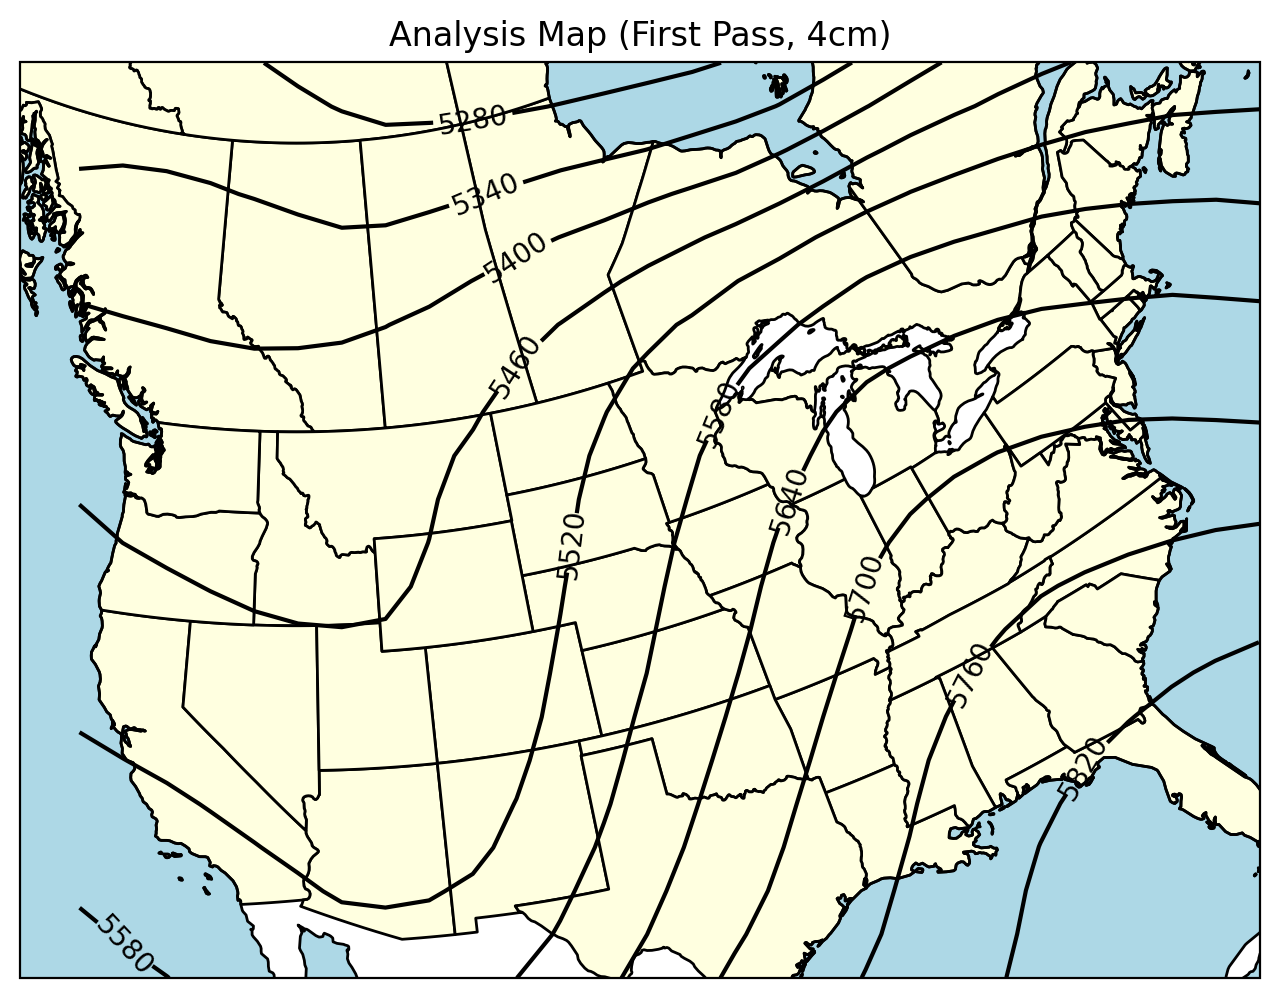

In [15]:
### Plot 500mb analyses over a map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g,Lat_g,first_pass,colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (First Pass, 4cm)')
plt.savefig("AnalysisFirstPass.png", dpi = 250)

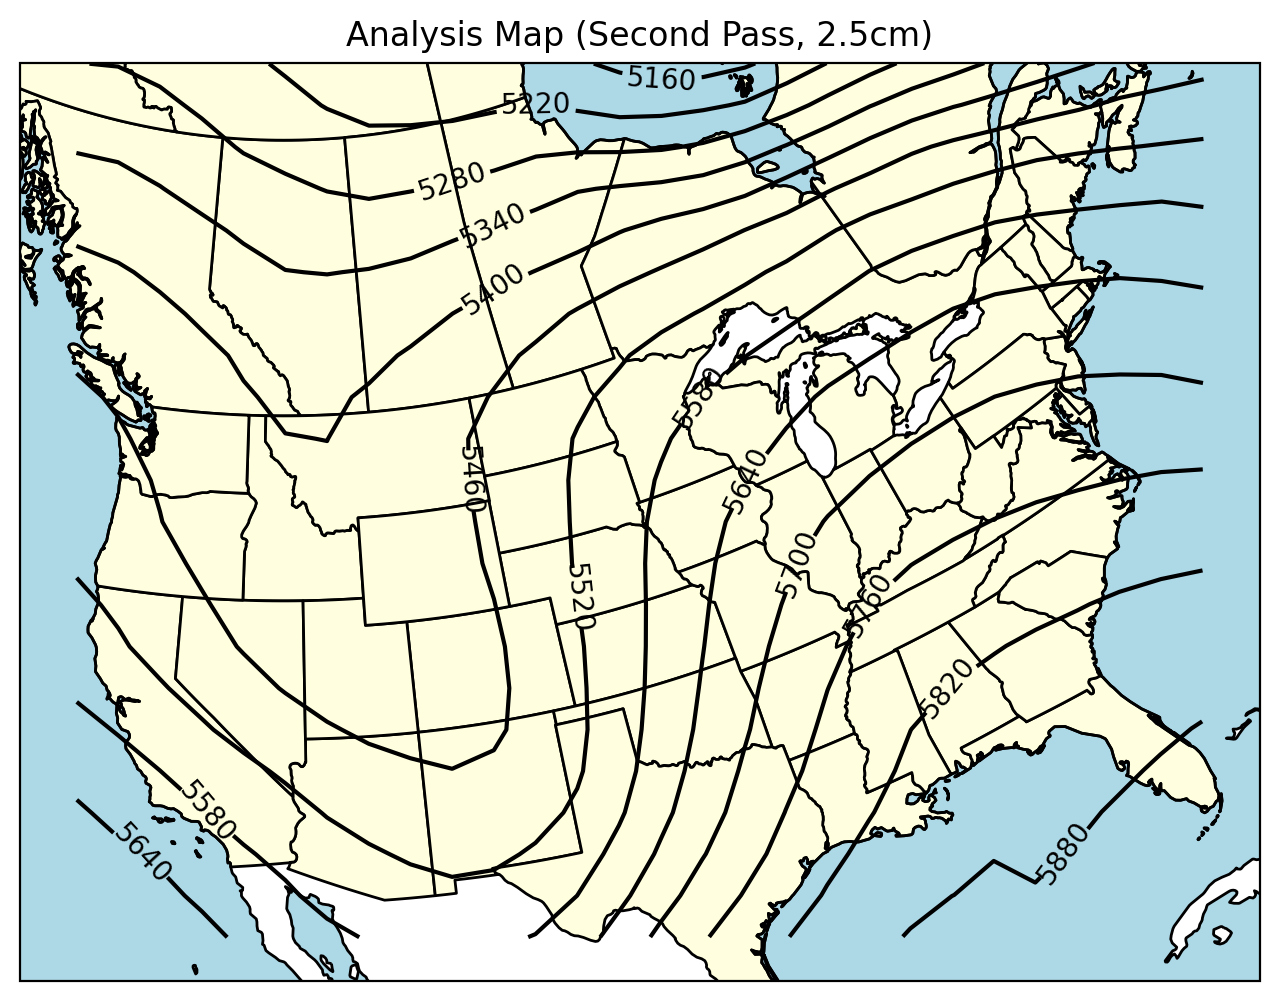

In [16]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g,Lat_g, second_pass, colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (Second Pass, 2.5cm)')
plt.savefig("AnalysisSecondPass.png", dpi = 250)

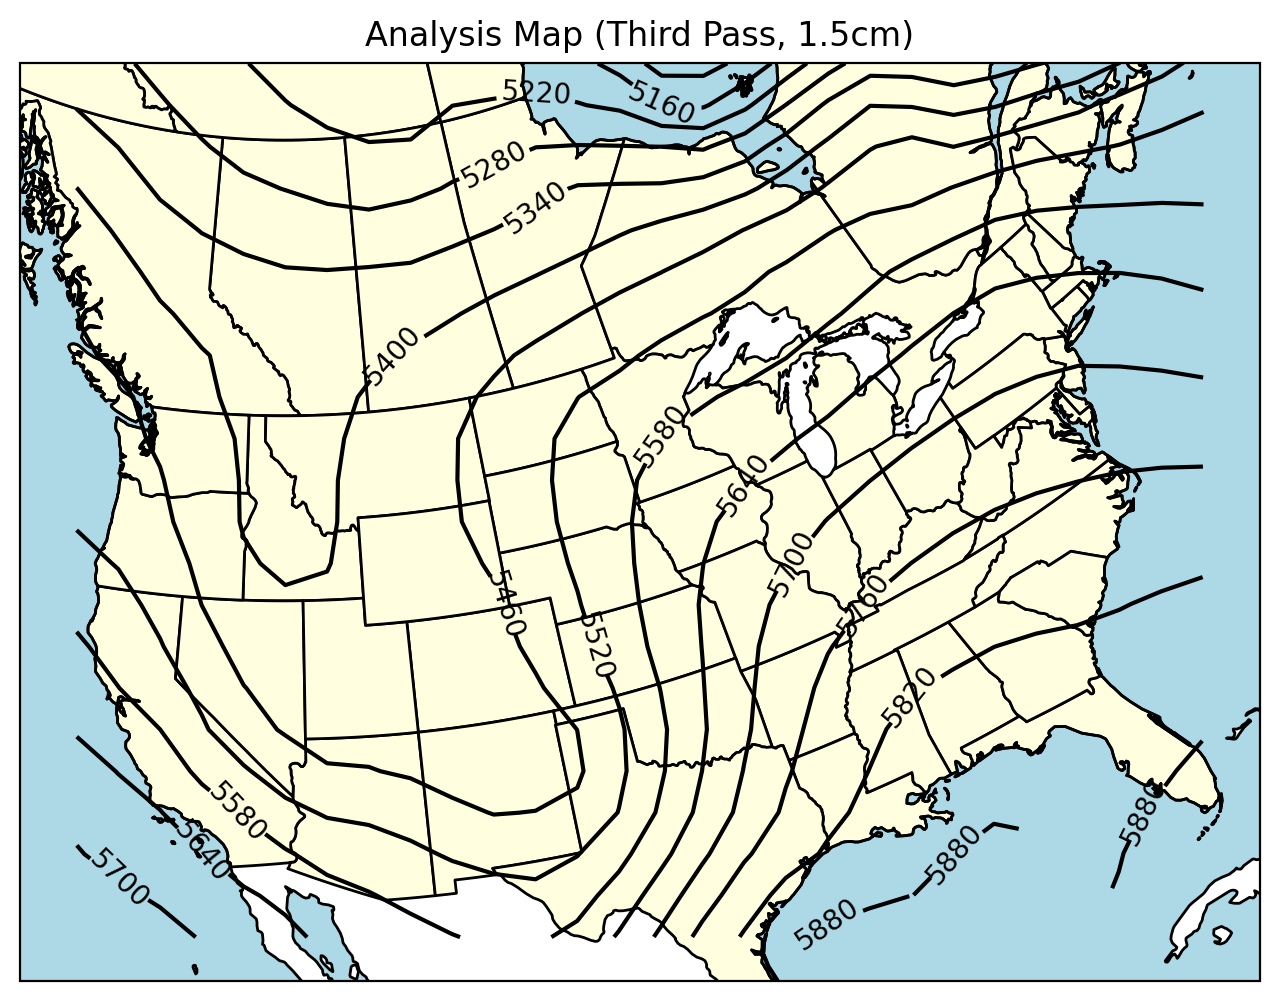

In [17]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g,Lat_g, third_pass, colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title('Analysis Map (Third Pass, 1.5cm)')
plt.savefig("AnalysisThirdPass.png", dpi = 250)

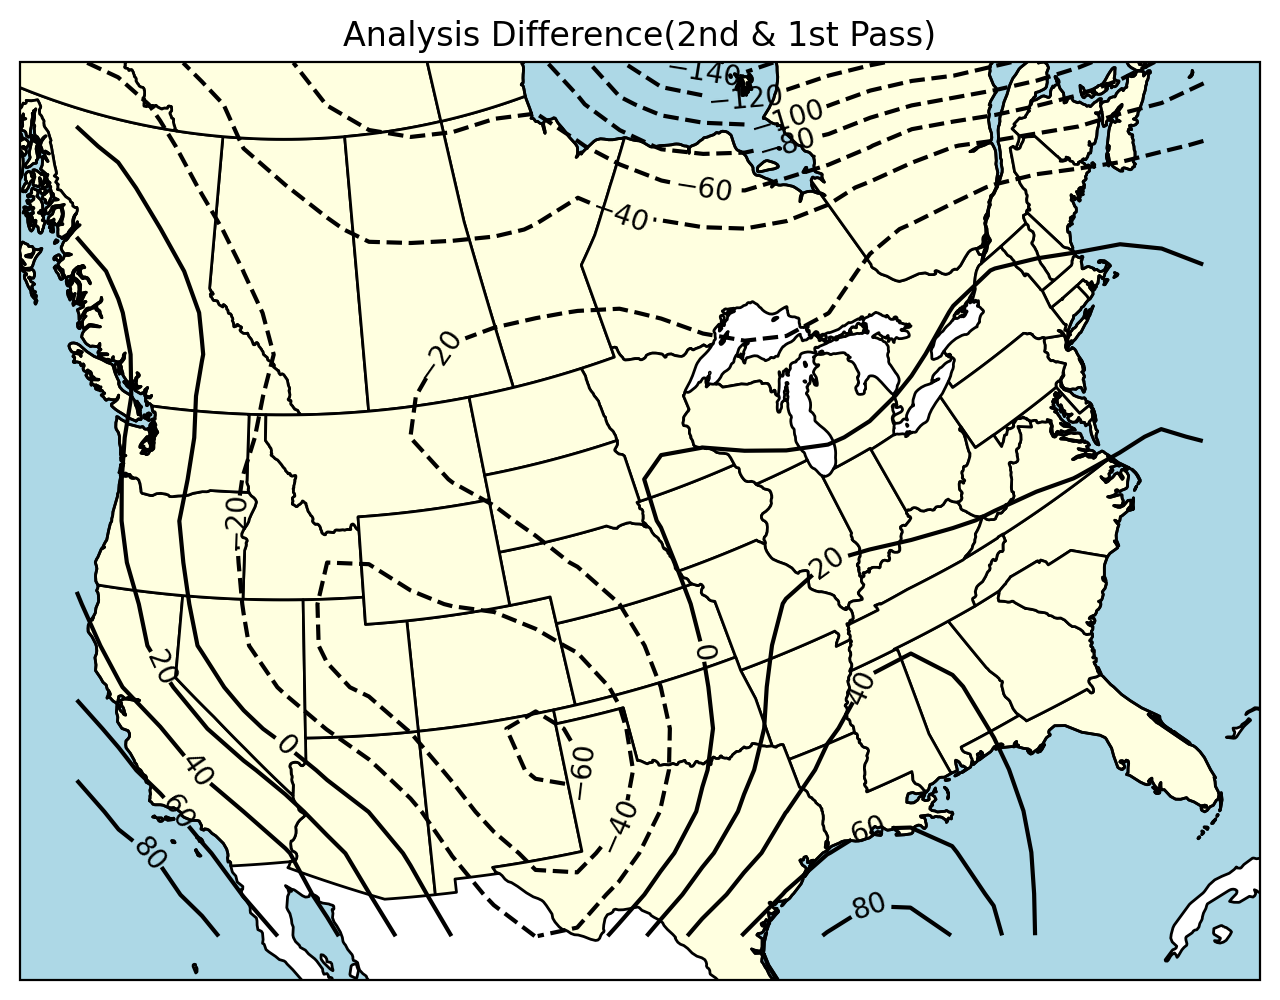

In [18]:
## Plot Analysis Differences ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')
 
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g, Lat_g,diff_21[:,:],colors='k',levels = np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,20))
plt.title('Analysis Difference(2nd & 1st Pass)')
plt.savefig("AnalysisDiff21.png", dpi = 250)

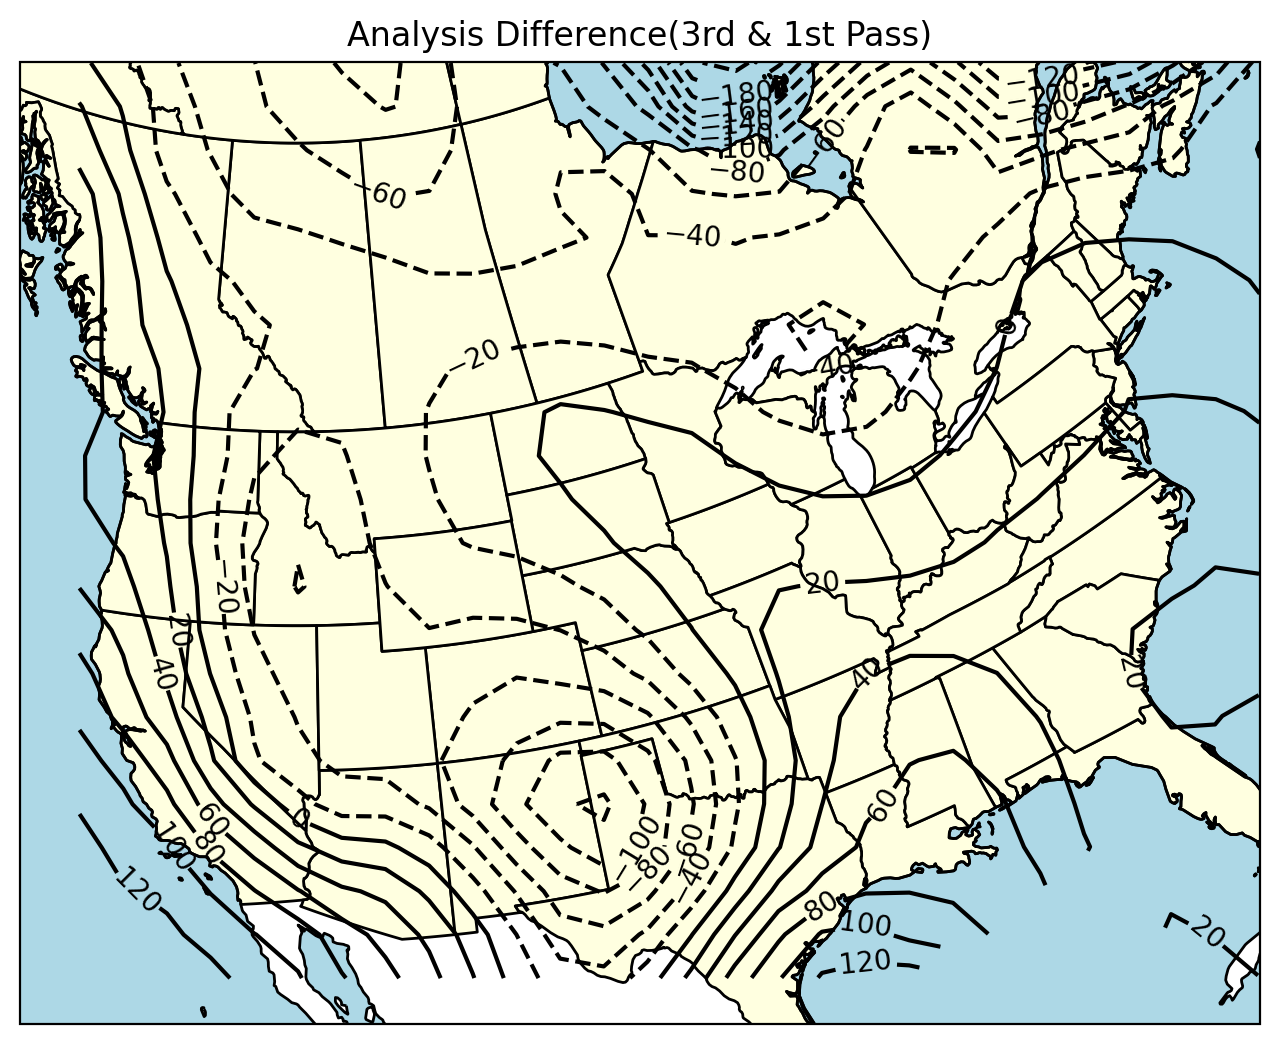

In [19]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')
 
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g, Lat_g,diff_31[:,:],colors='k',levels = np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,20))
plt.title('Analysis Difference(3rd & 1st Pass)')
plt.savefig("AnalysisDiff31.png", dpi = 250)

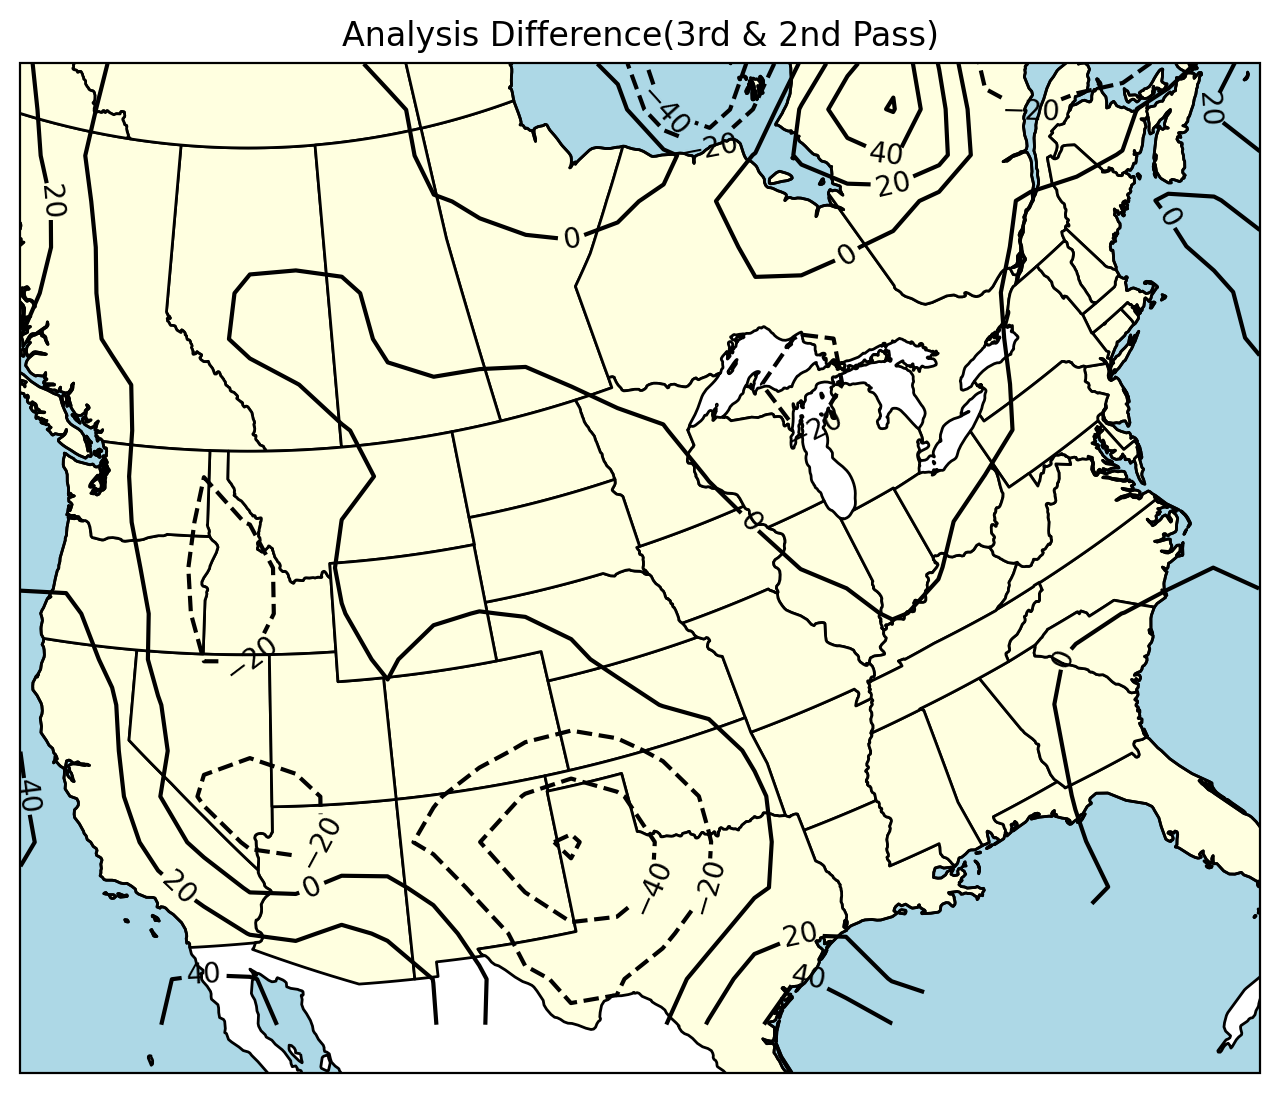

In [20]:
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES, facecolor = 'lightyellow')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.OCEAN, facecolor ='lightblue')
 
#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
cs1 = ax1.contour(Lon_g, Lat_g,diff_32[:,:],colors='k',levels = np.arange(-8000,8000,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels = np.arange(-8000,8000,20))
plt.title('Analysis Difference(3rd & 2nd Pass)')
plt.savefig("AnalysisDiff32.png", dpi = 250)

In [21]:
### Store the analyses in text files ###
file1_first = open("FirstPass", "w+")
file1_second = open("SecondPass", "w+")
file1_third = open("ThirdPass", "w+")
first_pass_txt = str(first_pass)
second_pass_txt = str(second_pass)
third_pass_txt = str(third_pass)
file1_first.write(first_pass_txt)
file1_second.write(second_pass_txt)
file1_third.write(third_pass_txt)
file1_first.close()
file1_second.close()
file1_third.close()

In [22]:
### Store the difference fields in text files ###
file1_diff21 = open("Diff21", "w+")
file1_diff31 = open("Diff31", "w+")
file1_diff32 = open("Diff32", "w+")
diff21_txt = str(diff_21)
diff31_txt = str(diff_31)
diff32_txt = str(diff_31)
file1_diff21.write(diff21_txt)
file1_diff31.write(diff31_txt)
file1_diff31.write(diff31_txt)
file1_diff21.close()
file1_diff31.close()
file1_diff32.close()

In [23]:
### Store RMS values in text file ###
file1_rms = open("RMSOutput", "w+")
rms_txt = str(rmsarray)
file1_rms.write(rms_txt)
file1_rms.close()

In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
Similar to the function fitting assignment, we see a trough over the western US, and a ridging pattern over the eastern US. 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
The first pass is the smoothest of the three passes. Interestingly, the trough seems to become more outlandish and pointed/deep, while the ridging pattern
seems to flatten a bit. Additionally, the height gradients become more pronounced with more corrections. 
This is likely because the the initial pass is just representative of the observations fit to the grid, while the second and third passes introduce
corrections and the background becomes too similar to the observations. 
    
3 - What happens as you increase the number of successive correction passes?  Is this 
    desirable?  Why or why not?
As mentioned in question 2, increasing the successive correction passes makes the background more similar to the observations, which could be good and bad. 
If the observations are good, this could be good for seeing smaller scale, more local features. However, if you want to evaluate larger scale features this
wouldn't really be desirable, or if the observations aren't good, then having the background heavily influence by observations with more passses would make 
for a bad analysis. 
    
'''